# Diffusion model

Translation of Justin's [tutorial](http://gru.stanford.edu/doku.php/tutorials/diffusion) from MATLAB.

[Signal Detection Theory](http://gru.stanford.edu/doku.php/tutorials/sdt) can be used to get bias-free measures of subject's sensitivity, predict performance on a two alternative forced choice and has been quite useful both in psychophysics and in cognitive neuroscience where it is often used to link physiology to behavior. But, one thing it completely sweeps under the carpet is time. There is no notion of how the decision process evolves over time and so therefore it has nothing to say about reaction times. So, diffusion models.

There are many variations of diffusion models, but the basic flavor is to think of a decision variable which accumulates evidence for a choice (generically, let's call that “A”) against another choice (“B”). In the Newsome et al., experiments these would be a choice for, say, leftwards vs rightwards motion. The decision variable gets momentary evidence that is corrupted by noise (can be anything, but typically gaussian) which is integrated across time. This causes the decision variable to move randomly (brownian motion) until it hits (gets absorbed by) one of the decision criterion (bounds). Whichever bound it hits first is the decision that wins. When it hits gives you the reaction time. You should have the following picture in your head of a single trial:

![](http://gru.stanford.edu/lib/exe/fetch.php/tutorials/diffusionsingletrial.png?w=500&h=250&cache=cache)

The evolution of the decision variable is literally governed by integrating random draws from a gaussian distribution whose mean governs how much evidence is acquired in each time interval and whose standard deviation is associated with how noise that evidence is. So, if you have strong evidence for choice “A”, then you would have a large positive mean. For example, if a neuron in MT fires a lot in its preferred direction, then it will contribute a large mean and the trial to trial variability will correspond to the standard deviation of the evidence. Sometimes, due to the randomness of each sample from the evidence distribution, the decision variable may take a random walk to the other boundary and a wrong decision will be made. Note, that we are, for the purpose of this tutorial, always simulating a decision process in which the correct decision is “A” (upper bound), since we are adding a positive mean to evidence.


![](http://gru.stanford.edu/lib/exe/fetch.php/tutorials/decisiononetrialwrong.png?w=500&h=250&cache=cache)

Across many trials then, having a small amount of moment-by-moment evidence (mean of the gaussian variable) relative to variability (standard deviation of the gaussian variable) accumulation will more often go to the correct bound then the incorrect bound. The time it takes to get to each bound (RT) forms a distribution and you can see that the distributions have a bit of a skew to them.

![](http://gru.stanford.edu/lib/exe/fetch.php/tutorials/diffusionmany.png?w=500&h=250&cache=cache)

Ok. Get the basic idea? Let's try it out ourselves.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Simulate a trial

So, the idea is to have a decision variable that over time integrates information from a random gaussian process with some mean and standard deviation. Let's start by simulating that (arbitrarily) for a process with mean = 0.1 and standard deviation = 1. Let's have the decision variable, d, start at 0. We will stop the process when it hits either the top bound, A, or the bottom bound -B. For this case, we will just have those bounds equidistant from the starting point. So A=B, and we'll just stop the process when the absolute value of d gets bigger than A. Let's make A for this simulation 10. Got it?


In [3]:
mean = 0.1
std = 1
A = 10

dv = [0]
while abs(dv[-1]) < A:
    evidence = np.random.normal(mean, std)
    dv.append(dv[-1] + evidence)

Now plot it:

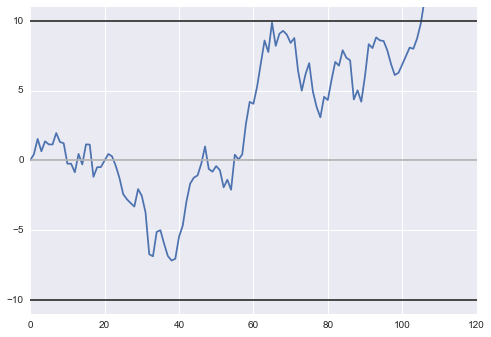

In [16]:
f, ax = plt.subplots()
ax.plot(dv)
ax.axhline(0, c=".7")
ax.axhline(A, c=".2")
ax.axhline(-A, c=".2")
ax.set(ylim=(-A - 1, A + 1));

## Simulate multiple trials

Ok, good so far? Let's try to run that process for multiple trials (say n=100) and plot each trial as we go along. We should also keep track of what decision was made (i.e. which bound was chosen) and when that decision was made. That way at the end we can look at the predicted percent correct and the reaction time distribution - these are the basic predictions of the model. To do this, we'll write a function to compute the d.v. over time on a single trial and then call it multiple times.

In [5]:
def single_trial(mean, std, A):
    dv = [0]
    while abs(dv[-1]) < A:
        evidence = np.random.normal(mean, std)
        dv.append(dv[-1] + evidence)
    return dv

Let's plot it:

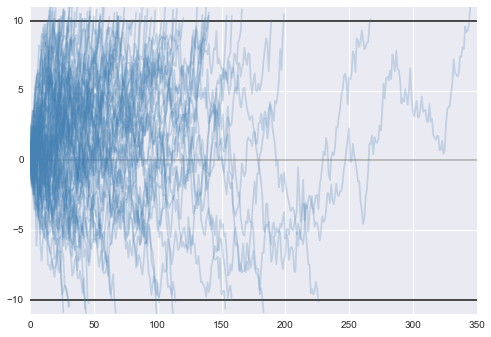

In [6]:
trials = [single_trial(mean, std, A) for _ in range(100)]

f, ax = plt.subplots()

for dv in trials:
    ax.plot(dv, c="steelblue", alpha=.25, zorder=3)

ax.axhline(0, c=".7")
ax.axhline(A, c=".2")
ax.axhline(-A, c=".2")
ax.set(ylim=(-A - 1, A + 1));

Ok. So, let's see what we got. Calculate the percentage of correct trials vs the percentage of incorrect trials (what do you expect these to be like?)

In [7]:
correct = np.array([t[-1] > 0 for t in trials])
print "Accuracy rate {:.2f}".format(correct.mean())

Accuracy rate 0.84


Now let's look at the reaction time distribution:

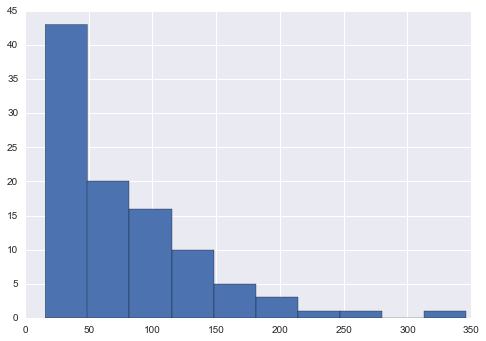

In [15]:
rts = np.array([len(t) for t in trials])
plt.hist(rts);

What does the distribution look like? Is it gaussian? Is it skewed? Why does it have the shape that it does?

If you have that all working, then try the same simulation, but don't give any sensory evidence. Decisions are just based on chance fluctuations. You should expect percent correct to equal percent errors. Try it.

In [9]:
noise_trials = [single_trial(0, std, A) for _ in range(100)]

Ok, what percent correct and incorrect did you get. What happened to reaction times? To answer these questions, let's define a function to plot the diffusion results like the images at the beginning of the tutorial:

In [10]:
def plot_diffusion(trials):

    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,
                                     gridspec_kw={"height_ratios": (.25, .5, .25)})

    for dv in trials:
        ax2.plot(dv, c="steelblue", alpha=.25, zorder=3)

    ax2.axhline(0, c=".7")
    ax2.axhline(A, c=".2")
    ax2.axhline(-A, c=".2")
    ax2.set(ylim=(-A - 1, A + 1));
        
    correct = np.array([t[-1] > 0 for t in trials])

    ax1.text(.95, .95, "Correct proportion: {:.2f}".format(correct.mean()),
             ha="right", va="top", transform=ax1.transAxes)
    ax3.text(.95, .05, "Error proportion: {:.2f}".format(1 - correct.mean()),
              ha="right", va="bottom", transform=ax3.transAxes)
    
    rts = np.array([len(t) for t in trials])

    bins = np.linspace(0, rts.max(), len(trials) * .15)
    if correct.any():
        ax1.hist(rts[correct], bins=bins, color="steelblue")
    if not correct.all():
        ax3.hist(rts[~correct], bins=bins, color="steelblue")

    ymax = max(ax1.get_ylim()[1], ax3.get_ylim()[1])
    ax1.set(ylim=(0, ymax))
    ax3.set(ylim=(0, ymax))
    ax3.invert_yaxis()

    ax1.set(ylabel="Count")
    ax2.set(ylabel="D.V.")
    ax3.set(xlabel="Time", ylabel="Count")

    f.tight_layout()

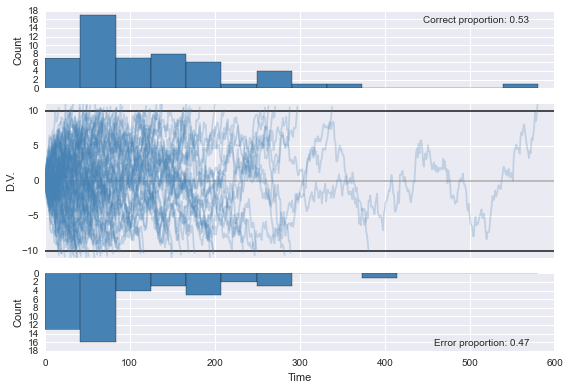

In [11]:
plot_diffusion(noise_trials)

The thing to note about this, is that even thought the gaussian generating process had 0 mean - you still ended up on each trial meandering to one of the bounds. Random walks don't just jitter around the starting place and never go anywhere - by integration of random values they end up, by chance, going somewhere.

Try playing around with the model in different ways - what does changing the height of the bounds do? Or changing the mean? Or, the standard deviation. What about using a different distribution, not gaussian (why might you want to do that?). What about the starting point of the process?

In [12]:
from IPython.html.widgets import interact

:0: FutureWarning: IPython widgets are experimental and may change in the future.


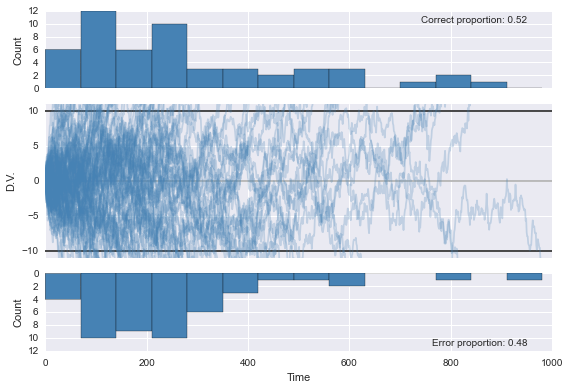

In [13]:
@interact
def diffusion_process(mean=(-.5, .5), std=(0., 2), A=(0, 20)):
    trials = [single_trial(mean, std, A) for _ in range(100)]
    plot_diffusion(trials)

Ok, so you should now have a rough idea of how changing different parameters of the model can affect the accuracy and reaction times. So, er, Pop quiz, what parameters can you change to affect the accuracy and reaction time?

## Fit behavioral data


Ok, so that's all great, but how do you fit this beast to behavioral data? Well, one answer is to do just what you have been doing - simulate many variations of the parameters until you get something that matches by some fit criteria (usually maximizes the likelihood of your data). A non-linear search algorithm can adjust the parameters for you to search the space of parameters more efficiently and you just let it go at it and come back some time later to see what it gets. While this may seem inefficient, there are times when you have to do this. In particular, if you make the model more complicated (various versions have been proposed in which you add randomness not just to the moment to moment evidence, but also to the starting point for instance) or if you want to fit the whole shape of your reaction time distributions you may wish to do a fit like this.

But, if you just want to fit your percent correct and mean reaction times. There are closed-form solutions that give you equations for how to do this.

$$P_{correct} = \frac{1}{1 + e^{-2\mu A}}$$

This first equations tells you what to expect for the probability correct, given the bounds (assuming symmetrical bounds) A and the mean of the process μ. Where does this come from? Well it comes from a mathematical derivation which is a bit complicated (see: [here](https://www.shadlenlab.columbia.edu/publications/publications/mike/okinawa_chapter2006.pdf) for a helpful primer). But, you can think of it as the solution to the following problem. Given bounds A and a gaussian process with some mean and standard deviation, what is the probability that the process will end up at the top bound instead of the bottom bound. The solution is the above equation.

Let's take a look at the form of the equation and see if it makes sense. How does it change as you make μ bigger and bigger?



In [44]:
A = 1
mu = np.linspace(0, 10, 100)
p = 1 / (1 + np.exp(-2 * mu * A))

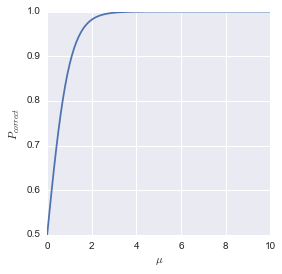

In [45]:
f, ax = plt.subplots(figsize=(4, 4))
ax.plot(mu, p)
ax.set(xlabel="$\mu$", ylabel="$P_{correct}$", ylim=(.5, 1));

What does it look like? Where does it start and where does it end? Does the shape make sense?

But, wait a second. What happened to the standard deviation? You know from above that it matters. But, it's not in the equation, why? Well, it actually should be. The full equation should read:

$$P_{correct} = \frac{1}{1 + e^\frac{-2 \mu A}{\sigma ^ 2}}$$

Trouble is, changing A and changing sigma amount to the same thing, just in opposite directions. They are both unobserved variables, so you cannot estimate both of them. So, you just estimate one and say that you estimate the ratio of the two. You might say the same thing about μ and A, but take a look first at the solution for when on average you hit the bound:

$$RT_{mean} = \frac{A}{\mu}\tanh{\mu A}$$

Ok, what shape does that give you? Well, plot it as a function of μ just like you did for the percent correct equation and see what it looks like.

In [46]:
rt = A / mu * np.tanh(mu * A)

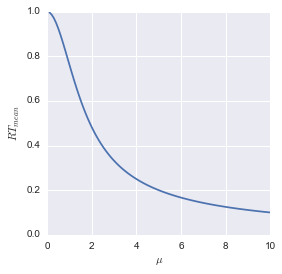

In [47]:
f, ax = plt.subplots(figsize=(4, 4))
ax.plot(mu, rt)
ax.set(xlabel="$\mu$", ylabel="$RT_{mean}$");

What do you get for that? Does the shape of it make sense? What happens as mu gets larger and larger?

One thing to note here. This is the average reaction time. Remember that the distributions from above look skewed? This does not tell you anything about the skew of the distribution, just the central tendency. The model actually predicts a particular skewed shape of the reaction time distribution and that may be important. It is not fit, when you use the above equation.

Another thing. What are the units here? We want them to be in milliseconds, for example. If the monkey takes, say, 800ms to make the decision, then this equation needs to be fit such that you get a value of 800. Right? So, change A and see what happens. Can you get a value of 800 out of the equation?

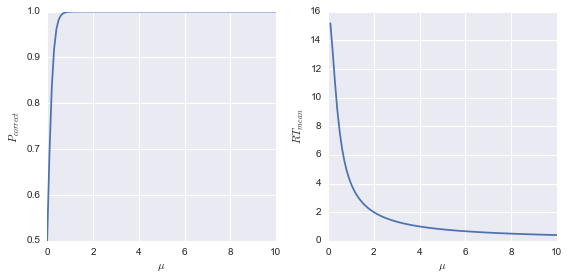

In [50]:
@interact
def vary_bound_height(A=(0, 100)):

    mu = np.linspace(0, 10, 100)
    p = 1 / (1 + np.exp(-2 * mu * A))
    rt = A / mu * np.tanh(mu * A)

    f, (ax_p, ax_rt) = plt.subplots(1, 2, figsize=(8, 4))

    ax_p.plot(mu, p)
    ax_p.set(xlabel="$\mu$", ylabel="$P_{correct}$", ylim=(.5, 1))
    
    ax_rt.plot(mu, rt)
    ax_rt.set(xlabel="$\mu$", ylabel="$RT_{mean}$")

    f.tight_layout()

You see that you get some value of mu that will give you 800 ms? You can now imagine playing around with values of mu and A to fit your reaction time data. But, what's the longest reaction time you should expect for some A and $\mu$? Is it actually plotted on the graph?

No. The computation A / $\mu$ results in a NaN when $\mu$ is 0, so it is not showing up on the graph.

But, we may want to know what to expect for a reaction time when $\mu$ is 0 and there is no sensory evidence (this is a very important case, right? Remember how choice probabilities were calculated in the Newsome experiment?) So, to do that you need to take limits:

$$RT_{mean} = \lim_{\mu \rightarrow 0}{\frac{A}{\mu}\tanh{\mu A}} = A^2$$

Ok. Good, so now we have an expression for the reaction times as a function of all possible μ

But, hey, wait a second. Notice something else here? What value is the shortest reaction time that the model predicts?

In the limit, 0. If you make mu really large (lots of evidence), the equation predicts that you could reach the bound ever faster, in no time at all!

But, this isn't really true for behavioral data. There must be some inherent delays associated with the time visual input is transduced and motor delays, at least, right? So, to fix that people put in, a, well, fudge factor - an independent “non decision” time. So, you get another free parameter to fit:

$$RT_{mean} = \frac{A}{\mu}\tanh{\mu A} + \tau_{nondecision}$$


## Fit behavioral data from motion task

From the above, we now know that to fit behavioral data, we have two free parameters μ and A. How do Shadlen et al., fit their behavioral data? Well they know that as you increase motion coherence, that neurons in MT increase their response approximately linearly [Britten KH, Shadlen MN, Newsome WT, Movshon JA (1993) Vis Neurosci 10:1157–1169](http://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=pubmed&id=8257671&retmode=ref&cmd=prlinks)). Here are a few examples of MT neurons responding increasing (or decreasing) as motion coherence is increased in their preferred (or anti-preferred) direction:

![](http://gru.stanford.edu/lib/exe/fetch.php/tutorials/mtmotionco.png?w=&h=&cache=cache)

So, they assume that increasing coherence (C) increases the μ of the evidence process linearly. You need a scaling parameter, k, to get the parameters right. So, the equations they use, are simply the ones from above where μ has been replaced with kC (remember that C is known to them - it is the motion coherence that they used).

Pop quiz. What would you do if you were trying to model decisions and you changed image contrast, not coherence?

You should make $\mu$ change according to the sigmoidal equation (called a Naka-Rushton equation) that is used to model neurons response as a function of contrast.

So, let's take some values from fits to monkey behavioral data from Huk & Shadlen, 2005, Figure 3. Where k = 0.426, A = 22.811 and $\tau$ (non decision time) = 417ms. Coherence of motion is varied from 0 to .50. What do we get?

In [67]:
k = 0.426
A = 22.811
tau = 417

C = np.linspace(0, .5, 100)

p = 1 / (1 + np.exp(-2 * k * C * A))
rt = (A / (k * C)) * np.tanh(k * C * A) + tau

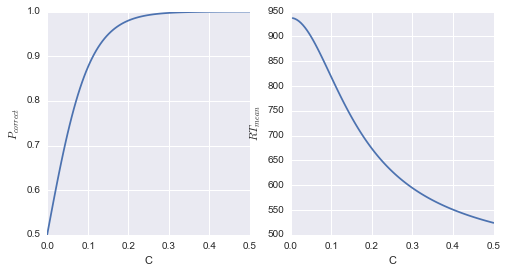

In [70]:
f, (ax_p, ax_rt) = plt.subplots(1, 2, figsize=(8, 4))

ax_p.plot(C, p)
ax_p.set(xlabel="C", ylabel="$P_{correct}$", ylim=(.5, 1))

ax_rt.plot(C, rt)
ax_rt.set(xlabel="C", ylabel="$RT_{mean}$");

It is convenient to plot on the same graph, the performance for the opposite motion direction as well (typically because we are studying a neuron and we want to know about choices made in the preferred direction vs the anti-preferred direction). When we do this, by convention, we call negative motion coherence more evidence for motion in the anti-preferred direction and we plot as a function of choices to the preferred direction. Try and plot the full curve this way.



In [71]:
C = np.linspace(-.5, .5, 100)

p = 1 / (1 + np.exp(-2 * k * C * A))
rt = (A / (k * C)) * np.tanh(k * C * A) + tau

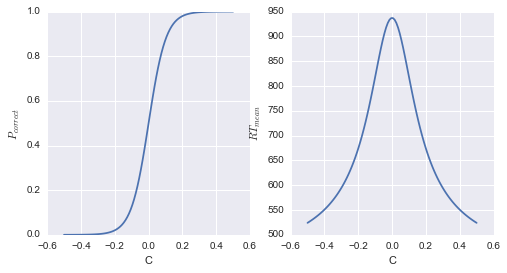

In [72]:
f, (ax_p, ax_rt) = plt.subplots(1, 2, figsize=(8, 4))

ax_p.plot(C, p)
ax_p.set(xlabel="C", ylabel="$P_{correct}$", ylim=(0, 1))
    
ax_rt.plot(C, rt)
ax_rt.set(xlabel="C", ylabel="$RT_{mean}$");

So, that is the solution using the equations. Does it actually match our simulation? Well, try it out. Set the parameters from above, for a low coherence, say 0.05, and see if you get the expectation from the equations. BTW, what is the expectation?

In [100]:
C = 0.05
p = 1 / (1 + np.exp(-2 * k * C * A))
rt = (A / (k * C)) * np.tanh(k * C * A) + tau
print("Model predictions: {:.2f} accuracy; {:.0f} mean RT".format(p, rt))

Model predictions: 0.73 accuracy; 900 mean RT


In [105]:
trials = [single_trial(k * C, 1, A) for _ in range(100)]

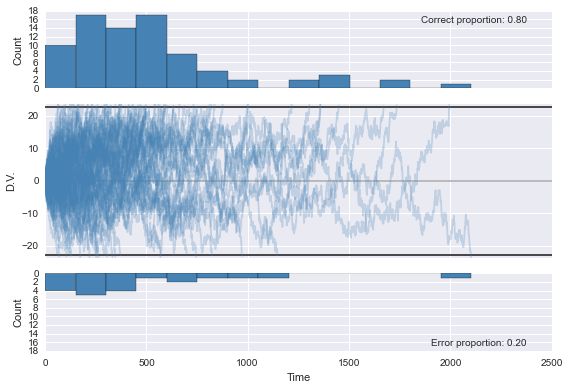

In [106]:
plot_diffusion(trials)

In [107]:
rts = [len(t) for t in trials]
print("Mean RT: {:.0f} ms".format(np.mean(rts) + tau))

Mean RT: 937 ms


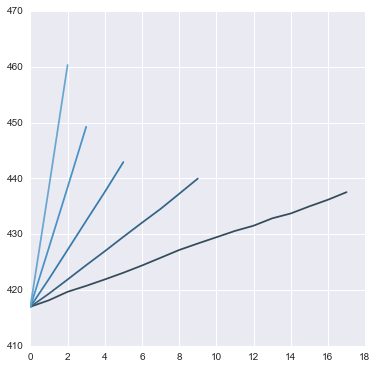

In [135]:
with sns.color_palette("Blues_d"):
    f, ax = plt.subplots(figsize=(6, 6))

for C in [3.2, 6.4, 12.8, 25.6, 51.2]:
    trials = [single_trial(k * C, 1, A) for _ in range(100)]
    median_rt = int(np.median([len(t) for t in trials]))
    avg_trials = [t[:median_rt] for t in trials if len(t) >= median_rt]
    ax.plot(np.mean(avg_trials, axis=0) + tau)